<a href="https://colab.research.google.com/github/licTomasPerez/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.7 MB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jt -t chesterish

1. Construir los operador x, p, conmutadores
2. 

In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import pickle
import math, cmath
from IPython.display import display, Math, Latex

In [3]:
def prod_basis(b1, b2):
  return [qutip.tensor(b,s) for b in b1 for s in b2]

def scalar_prod(op1, op2, rho0 = None):
  if op1.dims[0][0]!=op2.dims[0][0]:
    return "Incompatible Qobj dimensions"
  if rho0 is None:
    rho0 = qutip.qeye(op1.dims[0])/op1.dims[0][0]
  result = .5*(rho0*(op1*op2.dag()+op2.dag()*op1)).tr()
  result = result.real
  return result

def base_orth(ops, rho0):
  #print("base")
  if isinstance(ops[0], list):
    ops = [op for op1l in ops for op in op1l]
  #print(type(ops),type(ops[0]))
  dim = ops[0].dims[0][0]
  #print("dim=",dim)
  basis = []
  for op in ops: 
    alpha = [scalar_prod(op2, op, rho0) for op2 in basis]
    op_mod = op - sum([c*op2 for c, op2, in zip(alpha, basis)])
    op_mod = op_mod/(np.sqrt(scalar_prod(op_mod,op_mod,rho0)))
    basis.append(op_mod)
  return basis

def logM(rho):
  eigvals, eigvecs = rho.eigenstates()
  return sum([np.log(vl)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs) if vl > 0])

def sqrtM(rho):
  eigvals, eigvecs = rho.eigenstates()
  return sum([(abs(vl)**.5)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)])

def proj_op(K, basis, rho0):
  return sum([scalar_prod(b, K,rho0) * b for b in basis])

def rel_entropy(rho, sigma):
    val = (rho*(logM(rho)-logM(sigma))).tr()
    if abs(val.imag)>1.e-6:
        print("rho or sigma not positive")
        #print(rho.eigenstates())
        #print(sigma.eigenstates())
    return val.real

In [4]:
def bures(rho, sigma):
    val = abs((sqrtM(rho)*sqrtM(sigma)).tr())
    val = max(min(val,1.),-1.)
    return np.arccos(val)/np.pi
        
def maxent_rho(rho, basis):   
    def test(x, rho, basis):
        k = sum([-u*b for u,b in zip(x, basis)])        
        sigma = (.5*(k+k.dag())).expm()
        sigma = sigma/sigma.tr()
        return rel_entropy(rho, sigma)    
    res = opt.minimize(test,np.zeros(len(basis)),args=(rho,basis))
    k = sum([-u*b for u,b in zip(res.x, basis)])        
    sigma = (.5*(k+k.dag())).expm()
    sigma = sigma/sigma.tr()
    return sigma
 
def error_maxent_state(rho, basis, distance=bures):
    try:
        sigma = maxent_rho(rho, basis)
        return distance(rho,sigma)
    except:
        print("fail error max-ent state")
        return None
       
def error_proj_state(rho, rho0, basis, distance=bures):
    try:
        basis = base_orth(basis, rho0)
    except:
      print ("orth error")
      raise
    try:
        sigma = proj_op(logM(rho), basis, rho0).expm()
        sigma = (sigma+sigma.dag())/(2.*sigma.tr())
    except:
      print("gram error")
    try:
        return distance(rho, sigma)
    except:
        print("fail error proj state")
        return None

In [5]:
N = 3            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

id2 = qutip.qeye(2)
sx = .5*qutip.sigmax()
sy = .5*qutip.sigmay()
sz = .5*qutip.sigmaz()

sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    operator_list = []
    for m in range(N):
        operator_list.append(id2)
    operator_list[n] = sx
    sx_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sy
    sy_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sz
    sz_list.append(qutip.tensor(operator_list))

def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h):
  H = 0
  for n in range(N):
    H += -0.5*h[n]*sz_list[n]
        
  for n in range(N-1):
    H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
  return H

x_op = sum((.5 - sz_list[a])*a for a in range(N))
p_op = 1j * (x_op*Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) - Heisenberg_hamiltonian (N, Jx, Jy, Jz, h)*x_op)
comm_xp = .5*(x_op*p_op + p_op*x_op)
corr_xp = -1j*(x_op*p_op - p_op*x_op)
p_dot = 1j*(Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) * p_op - p_op * Heisenberg_hamiltonian (N, Jx, Jy, Jz, h))

entropy_VN = []
def callback_entropy_VN (t,rhot):
    entropy_VN.append(qutip.entropy_vn(rhot))

In [6]:
print(p_dot)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-0.04934802  0.          0.         -1.51745168  0.          0.09869604
  -0.50581723  0.        ]
 [ 0.          0.18505508 -0.04934802  0.         -0.02467401  0.
   0.         -0.48114321]
 [ 0.         -0.04934802  0.          0.          0.04934802  0.
   0.         -0.09869604]
 [-1.51745168  0.          0.          0.2344031   0.         -0.04934802
   0.02467401  0.        ]
 [ 0.         -0.02467401  0.04934802  0.         -0.2344031   0.
   0.         -1.44342964]
 [ 0.09869604  0.          0.         -0.04934802  0.          0.
   0.04934802  0.        ]
 [-0.50581723  0.          0.          0.02467401  0.          0.04934802
  -0.18505508  0.        ]
 [ 0.         -0.48114321 -0.09869604  0.         -1.44342964  0.
   0.          0.04934802]]


In [7]:
psi1_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list = []
psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list) ## siendo este un estado puro, su entropía de VN es cero
psi02 = qutip.tensor(psi2_list) 
psi0 = psi01+psi02 

In [8]:
print(psi02)

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [9]:
print(r"$$S(\psi_01)=$$", qutip.entropy_vn(psi01))
print(r"$$S(\psi_02)=$$", qutip.entropy_vn(psi02))
print(r"$$S(\psi_01+\psi_02)=$$", qutip.entropy_vn(psi01))

$$S(\psi_01)=$$ -0.0
$$S(\psi_02)=$$ -0.0
$$S(\psi_01+\psi_02)=$$ -0.0


In [10]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

In [11]:
def spin_dephasing(gamma):
  c_op_list = []
  collapse_weights = gamma * np.ones(N)
  for n in range(N):
        if collapse_weights[n] > 0.0:
            c_op_list.append(np.sqrt(collapse_weights[n]) * sz_list[n])
  return c_op_list

Considero un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

In [125]:
def callback(t, rhot):
  global rho
  rho = rhot


def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=bures, do_project=True):
    global rho
    basis = sx_list +  sy_list + sz_list
    #basis = [x_op, p_op, x_op**2, corr_xp, p_dot, p_op**2]
    H_H = Heisenberg_hamiltonian(N,Jx,Jy,Jz,h)
    globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
    rho0 = psi0 * psi0.dag()
    rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    # Hamiltoniano    

    obs = [x_op, p_op]
           #, x_op**2,p_op**2, corr_op, p_dot]

    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = spin_dephasing(gamma)
    rho = rho0
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
          rho = proj_op(logM(rho), basis, rho0)
          e0 = max(rho.eigenenergies())
          rho = rho - globalid * e0
          rho = rho.expm()
          trrho = (2.*rho.tr())
          rho = (rho+rho.dag())/trrho

        print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
      title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 10
2.078735578344281
2.0444250522695455
2.027294195220403
2.0218642012435164
2.0202429361172167
2.0197656202547836
2.0196256347331487
2.0195846257201735
2.019572615929455
2.0195690991056576
2.01956806930348
2.0195677677575232
2.0195676794592696
2.0195676536039167
2.0195676460329954
2.0195676438160928
2.019567643166945
2.0195676429768588
2.0195676429211904
2.019567642904889
2.0195676429001317
2.019567642898756
2.0195676428983287
2.019567642898203
2.019567642898157
2.019567642898153
2.0195676428981577
2.019567642898147
2.0195676428981386
2.019567642898138
2.019567642898147
2.0195676428981404
2.0195676428981417
2.0195676428981386
2.0195676428981373
2.0195676428981466
2.0195676428981404
2.0195676428981395
2.0195676428981475
2.01956764289815
2.0195676428981506
2.0195676428981515
2.019567642898145
2.01956764289814
2.019567642898138
2.019567642898147
2.0195676428981404
2.0195676428981475
2.019567642898147
2.0195676428981426
2.0195676428981546
2.019567642898146
2.0195676428981404
2.0

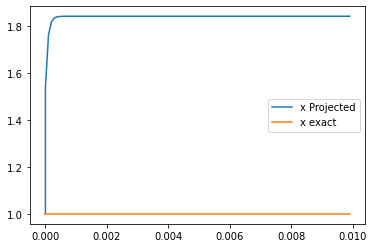

In [126]:
results = projected_evolution(x=.5, gamma = 1*np.e*-6, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=.0001, tmax = .01, distance=bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=.0001, tmax = .01, distance=bures,do_project=False)
plt.plot(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()


In [122]:
help(qutip.entropy)

Help on module qutip.entropy in qutip:

NAME
    qutip.entropy

FUNCTIONS
    concurrence(rho)
        Calculate the concurrence entanglement measure for a two-qubit state.
        
        Parameters
        ----------
        state : qobj
            Ket, bra, or density matrix for a two-qubit state.
        
        Returns
        -------
        concur : float
            Concurrence
        
        References
        ----------
        
        .. [1] https://en.wikipedia.org/wiki/Concurrence_(quantum_computing)
    
    entangling_power(U)
        Calculate the entangling power of a two-qubit gate U, which
        is zero of nonentangling gates and 1 and 2/9 for maximally
        entangling gates.
        
        Parameters
        ----------
        U : qobj
            Qobj instance representing a two-qubit gate.
        
        Returns
        -------
        ep : float
            The entanglement power of U (real number between 0 and 1)
        
        References:
     

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


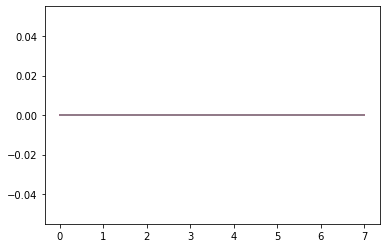

In [ ]:
results = projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1., tmax = 500., distance=bures)

#plt.plot(results[0], label="x")
plt.plot(results[1], label="p")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


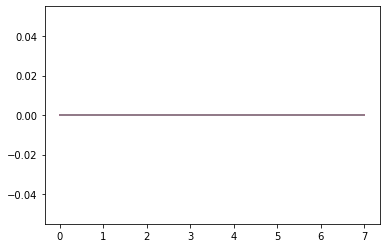

In [ ]:
results = projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1., tmax = 200., distance=bures)

plt.plot(results, label="p")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


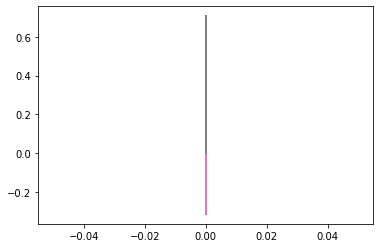

In [ ]:
plt.plot(results, corr_op)

base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2


Text(0.5, 1.0, ' BW Dinámica cerrada no gaussiana wb1=3.0 wb2=6.928203230275509')

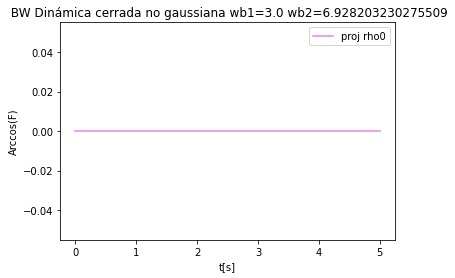

In [ ]:
result, title = projected_evolution(x=.1, gamma = 1*np.e**-2, omega_1=3., omega_2=np.sqrt(48), temp=1, gaussian=True, deltat=5., tmax=10., distance=bures)

plt.plot(result.times, result.projrho0_app, color="violet", label="proj rho0")
plt.xlabel("t[s]")
plt.ylabel("Arccos(F)")

plt.legend()
plt.title(title)

In [ ]:
a=4.2


In [ ]:
math.isnan(3.2)

False

In [ ]:
c_op_list = spin_dephasing(.1)
[type(o) for o in c_op_list]

[qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj]

In [ ]:
rho0 = qutip.tensor([.5*qutip.qeye(2) for k in range(3)])
id5 = .125*qutip.qeye(2**3)
print(rho0)
print(id5)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.125]]
Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.  